In [12]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
from cleanlab.rank import get_label_quality_scores
from sklearn.neighbors import KernelDensity
from utils import (
    compute_metrics,
    master_dataframe,
    create_metricwise_dict,
    draw_dot_plot,
)

In [2]:
!wget -P ./../dataset/ -nc https://cleanlab-public.s3.amazonaws.com/RegressionBenchmark/airquality_co.csv

File './../dataset/airquality_co.csv' already there; not retrieving.



In [3]:
loadpath = "./../dataset/airquality_co.csv"
data = pd.read_csv(loadpath, index_col=0)
data.head()

,time_slot,day_of_week,T,RH,AH,PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),true_label,given_label,true_error
0,evening,wednesday,13.6,48.9,0.7578,1046.0,1056.0,1692.0,1268.0,1.2078,1.2366,0
1,evening,wednesday,13.3,47.7,0.7255,955.0,1174.0,1559.0,972.0,0.9290,1.1747,0
2,evening,wednesday,11.9,54.0,0.7502,939.0,1140.0,1555.0,1074.0,1.0219,1.2747,0
3,evening,wednesday,11.0,60.0,0.7867,948.0,1092.0,1584.0,1203.0,1.0219,1.2511,0
4,night,wednesday,11.2,59.6,0.7888,836.0,1205.0,1490.0,1110.0,0.7432,1.1565,0


In [4]:
# use this to control which models to considered out of all the predications that are saved to local. 
models_to_be_considered = [
    "RandomForestMSE_BAG_L1",
    "LightGBM_BAG_L1",
    "NeuralNetFastAI_BAG_L1",
    "WeightedEnsemble_L2_CV",
    "oof",
]

# Update scoring method list, if you are adding new scoring techniques. 
scoring_methods = ["residual", "marginal_density", "discretised"]

# Update with name of metric to be considered. These are from compute_metrics(utils.py), consider adding new metric there.  
metrics_considered = [
    "auroc",
    "auprc",
    "lift_at_num_errors",
    "lift_at_100",
    "spearman_corr",
]

In [5]:
# Different score functions to be considered. ADD NEW SCORING METHOD IN THIS CELL
def score_residual(label: np.array, pred_values: np.array) -> np.array:
    """
    Returns label quality scores for each datapoint.
    Scores are calculated based on residual.

    Each score is continous value in range [0,1]
    1 - clean label (given label is likely correct).
    0 - dirty label (given label is likely incorrect).

    Parameters
    ----------
    label:
        original labels (or, given label) from dataset. Array of (N,)

    pred_values:
        predicted values from a custom regressor. Array of (N,)

    Returns
    -------
    scores:
        label quality scores for each datapoints

    """
    assert (
        label.shape == pred_values.shape
    ), f"shape of given_label {label.shape} and pred_values {pred_values.shape} are not same"

    residual = pred_values - label
    scores = np.exp(-abs(residual))
    return scores


def score_marginal_density(label: np.array, bandwidth: float = 0.05) -> np.array:
    """
    Returns label quality scores for each datapoint.
    Scores are calculated based on gaussian kernel density of given label.

    Parameters
    ----------
    given_label:
        original labels from dataset. Array of (N,)

    bandwidth:
        it controls the bandwidth on gaussian kernel to be considered while calcualting the overall density plot.
        values must be in range [0,1]

    Returns
    -------
    scores:
        label quality scores for each datapoints

    """
    # adding dimension to x_axis and given label
    x_lower = min(label)
    x_high = max(label)
    x_axis = np.linspace(x_lower, x_high, label.shape[0])[:, np.newaxis]
    label = np.array(label)[:, np.newaxis]

    # calculating the density and scores
    gaussian_density = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(label)
    log_density = gaussian_density.score_samples(x_axis)
    scores = np.exp(log_density)
    return scores


def score_discretised(
    given_label: np.array, pred_values: np.array, num_bins: int = 10
) -> np.array:
    """
    Returns label quality scores for each datapoint.
    Scores are calculated based by the discretising the given_label and then considering it as classification task.


    Each score is continous value in range [0,1]
    1 - clean label (given label is likely correct).
    0 - dirty label (given label is likely incorrect).

    Parameters
    ----------
    given_label:
        original labels from dataset. Array of (N,)

    pred_values:
        predicted values from a custom regressor. Array of (N,)

    num_bins:
        ``Default = 10``. the number of classes to be considered while discretising.

    Returns
    -------
    scores:
        label quality scores for each datapoints

    """
    assert (
        given_label.shape == pred_values.shape
    ), f"shape of given_label {given_label.shape} and pred_values {pred_values.shape} are not same"

    discrete_labels, bins = pd.cut(
        given_label,
        bins=num_bins,
        labels=np.arange(num_bins),
        right=False,
        retbins=True,
    )
    mid_of_bins = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)])

    pred_probs = np.array([softmax(-abs(val - mid_of_bins)) for val in pred_values])
    scores = get_label_quality_scores(np.array(discrete_labels), np.array(pred_probs))
    return scores

In [6]:
# Update the dictionary if you are adding any other scoring metrics.
# add if condition inside generate_metrics function - #LOCATION-IF
score_dict = {
    "residual": score_residual,
    "marginal_density": score_marginal_density,
    "discretised": score_discretised,
}


def generate_metrics(
    data: pd.DataFrame, pred_values: np.array, score_type: str = "residual"
) -> dict:
    assert (
        data.shape[0] == pred_values.shape[0]
    ), f"shape of dataframe and length of pred_values are not same."

    given_label = data["given_label"]
    true_label = data["true_label"]
    true_error = data["true_error"]
    true_diff = given_label - true_label

    # LOCATION-IF
    if score_type == "residual":
        scores = score_dict[score_type](given_label, pred_values)
    elif score_type == "marginal_density":
        scores = score_dict[score_type](given_label, bandwidth=0.05)
    elif score_type == "discretised":
        scores = score_dict[score_type](given_label, pred_values, num_bins=10)

    metrics = compute_metrics(
        scores=np.array(scores),
        true_error=np.array(true_error),
        true_diff=np.array(true_diff),
    )
    return metrics


def get_all_metrics(data: pd.DataFrame, scoring_method: list, pred_dict: dict) -> dict:
    metrics_data = {}
    for score_type in scoring_method:
        metrics_data[score_type] = {}
        for model_name, pred in pred_dict.items():
            metrics_data[score_type][model_name] = generate_metrics(
                data, pred, score_type=score_type
            )
    return metrics_data

In [7]:
# reads all the predictions saved in mentioned base path for predictions. 
predictions_basepath = "./../modeling/predictions/"
predictions_path = os.path.join(
    predictions_basepath, os.path.splitext(os.path.basename(loadpath))[0]
)
all_predictions_path = glob.glob(predictions_path + "/*.npy")

# generates a dictionary of prediction with respect to model considered in models_to_be_considered. 
predictions = {}
for path in all_predictions_path:
    model_name = os.path.splitext(os.path.basename(path))[0]
    if model_name in models_to_be_considered:
        """predictions = {model_name: prediction}"""
        predictions[model_name] = np.load(path)

# generate all metrics dictionary for every model considered
co_dataset_metrics = get_all_metrics(
    data, scoring_method=scoring_methods, pred_dict=predictions
)

In [8]:
# if dealing with multiple dataset, update this dictionary
dataset_metric_dict = {"airquality_co": co_dataset_metrics}

full_dataset = master_dataframe(dataset_metric_dict)
full_dataset.head(2)

,dataset,scoring_method,model,dataset_num_samples,dataset_num_errors,auroc,auprc,lift_at_num_errors,lift_at_100,spearman_corr,precision,recall,fpr,tpr
0,airquality_co,residual,oof,7344,365,0.531302,0.057734,1.157621,1.609644,0.012433,"[0.0497207464923035, 0.04959128065395095, 0.04...","[1.0, 0.9972602739726028, 0.9972602739726028, ...","[0.0, 0.0, 0.008597220232124947, 0.00859722023...","[0.0, 0.0027397260273972603, 0.002739726027397..."
1,airquality_co,residual,LightGBM_BAG_L1,7344,365,0.513858,0.051477,1.047371,1.207233,-0.018157,"[0.04984976782299918, 0.04971998360879661, 0.0...","[1.0, 0.9972602739726028, 0.9972602739726028, ...","[0.0, 0.0001432870038687491, 0.003725462100587...","[0.0, 0.0, 0.0, 0.005479452054794521, 0.005479..."


In [13]:
# extract metric-wise dictioanry, this used to generate plot having specific metric plotted for all the dataset and models. 
metric_based_dict = create_metricwise_dict(
    full_dataset, list_of_metrics=metrics_considered
)
print(metric_based_dict.keys())

dict_keys(['auroc', 'auprc', 'lift_at_num_errors', 'lift_at_100', 'spearman_corr'])


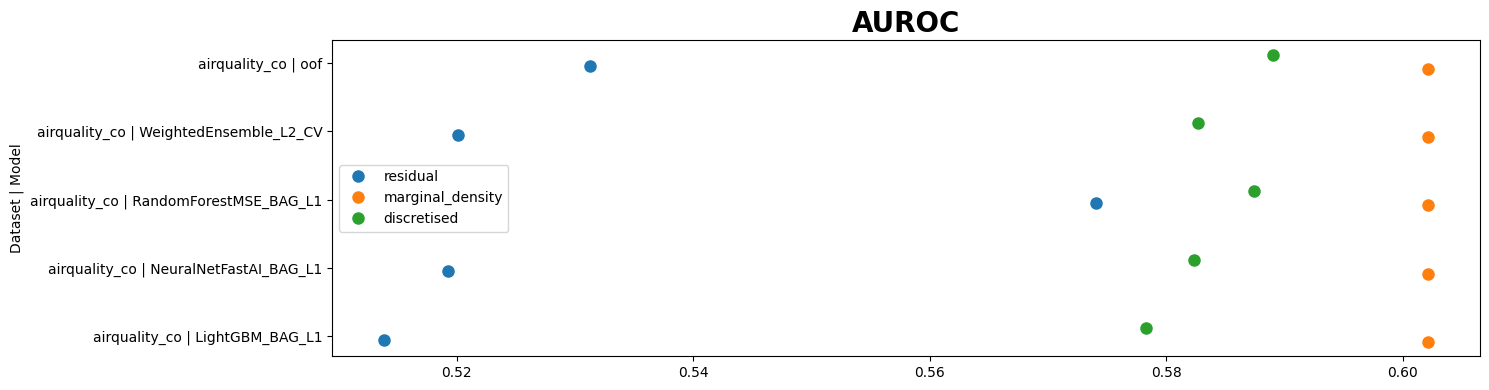

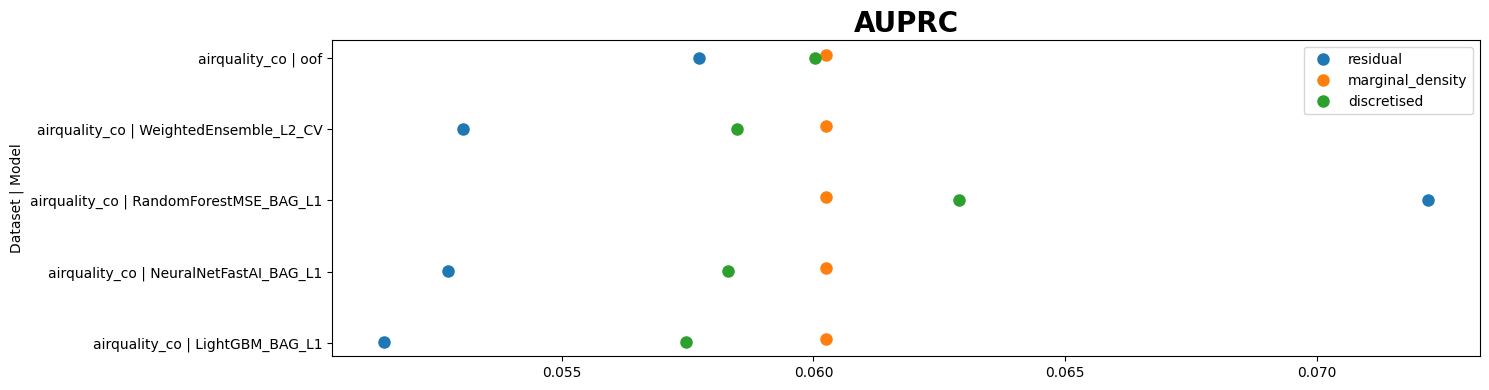

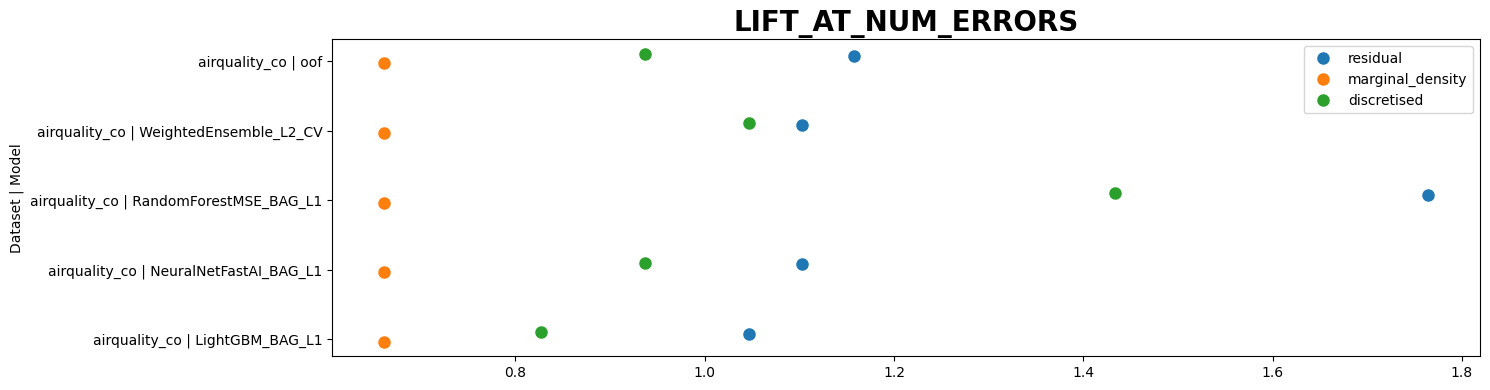

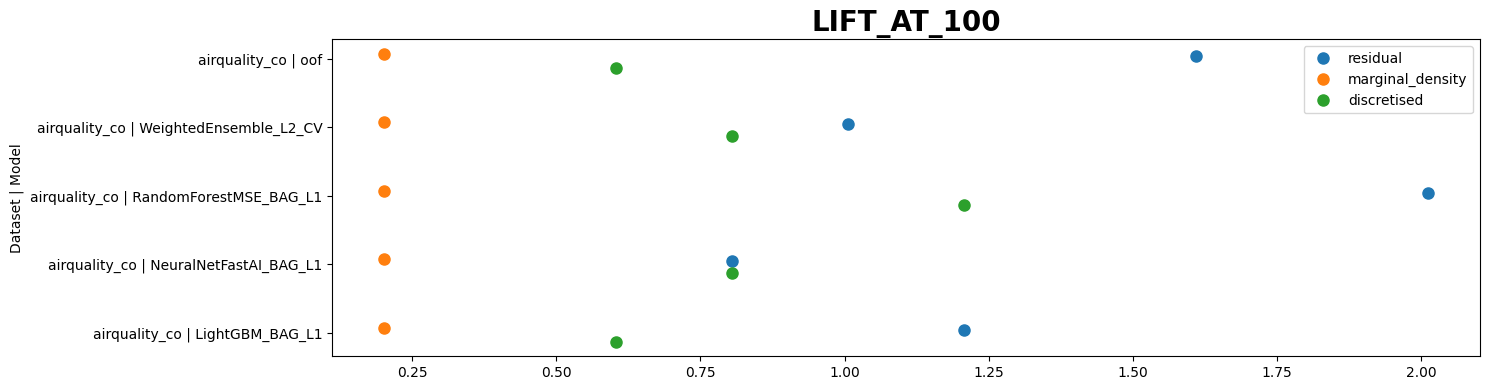

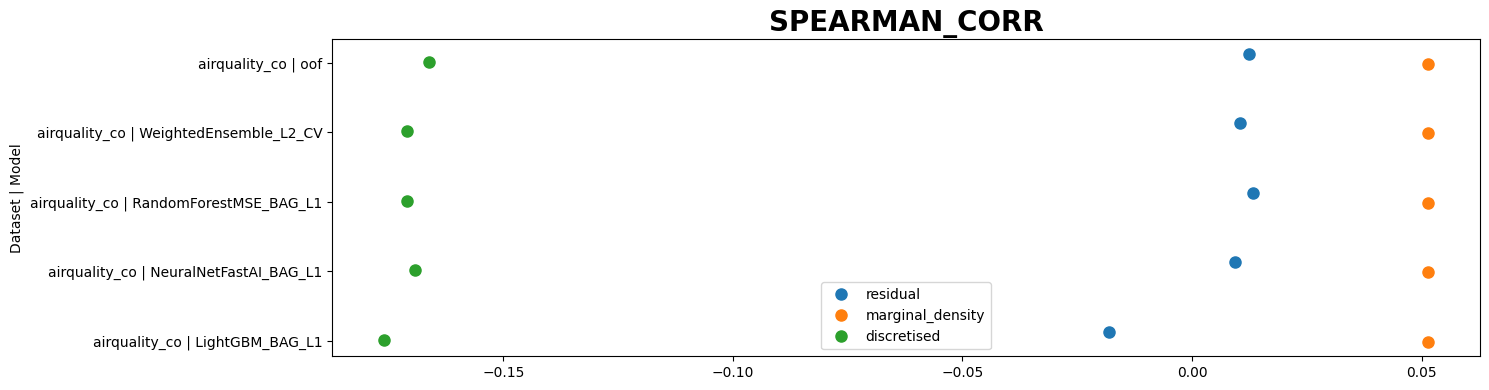

In [14]:
for metric in metrics_considered:
    draw_dot_plot(
        metric_based_dict[metric],
        scores_considered=scoring_methods,
        title=metric.upper(),
        figsize=(15, 4*len(dataset_metric_dict)),
    )